# Softening function and damage function

In [1]:
%reset -f
import sympy as sp
from sympy.plotting import plot as splot
sp.init_printing()

Let us consider a softening function of the form
\begin{align}
f(w) = c_1 exp( - c_2 w )
\end{align}
This is function should describe the decay of stress starting from the material tensile strength and continuously deminishing to zero.
The variable $w$ represents the crack opening and the parameters $c_1$ and $c_2$ are the material parameters.

In [2]:
c_1, c_2, w = sp.symbols('c_1,c_2,w')

In [3]:
f = c_1 * sp.exp(-c_2*w)

Let us plot the function to verify its shape for the material parameters set to the value 1

In [4]:
f_w = f.subs({'c_1':1, 'c_2':1})

In [5]:
splot(f_w, (w, 0, 10))

The function can be already used in this form. The question is however, how to set the material parameters $c_1$ and $c_2$. They can be directly associated to a particular type of material parameters - namely, to the tensile strength $f_\mathrm{t}$ and fracture energy $G_\mathrm{f}$ 

In [6]:
f_t, G_f = sp.symbols('f_t, G_f')

Softening starts at the level of the material strength so that we can set $f(w = 0) = f_\mathrm{t}$  to obtain the equation

In [7]:
Eq1 = f.subs({'w':0}) - f_t
Eq1

By solving for the $c_1$ we obtain the first substitution for our softening function.

In [8]:
c_1_subs = sp.solve({Eq1}, c_1)
c_1_subs

Thus, $c_1$ is equivalent to the tensile strength $f_\mathrm{t}$

The second possible mechanical interpretation is provided by the statement that softening directly represents the energy dissipation of a unit crack area. Thus, for large $w \rightarrow \infty$ it is equivalent to the energy producing a stress-free crack. This is the meaning of fracture energy.

We can thus obtain the fracture energy represented by the softening function by evaluating its integral in the range $w \in (0, \infty)$. 

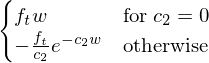

In [9]:
int_f_w = sp.integrate(f.subs(c_1_subs), w)
int_f_w

As $c_2 > 0$, only the second term matters.
The determinate integral
\begin{align}
\left[ - \frac{f_\mathrm{t}}{c_2} 
\exp(-c_2 w) \right]_0^{\infty}
\end{align}
is zero for $w = \infty$, so that the value in $w = 0$ delivers the result of the integral
\begin{align}
\frac{f_\mathrm{t}}{c_2} 
\end{align}

This integral is equal to the fracture energy $G_\mathrm{f}$.

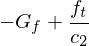

In [10]:
Eq2 = -int_f_w.args[1][0].subs({'w':0}) - G_f
Eq2

and the value of $c_2$ delivers the second substitution for the softening function

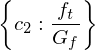

In [11]:
c_2_subs = sp.solve({Eq2}, c_2)
c_2_subs

The softening function with strength and fracture energy as a parameter now obtains the form

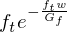

In [12]:
f_w = f.subs(c_1_subs).subs(c_2_subs)
f_w

Verify that the fracture energy is recovered at $w$ in infinity

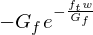

In [13]:
sp.integrate(f_w, w)

## How to apply the softening function to a zone?

If we wish to embed the softening behavior into a finite element simulation we encounter the problem that the deformation is not described by the crack opening $w$. The finite element discretization assumes by definition a smooth stran field $verepilon$ and there is no notion of discontinuity. 

As a consequence, we need to account for a length of the softening zone  $L_s$ which is actually equivalent to the size of the finite element.

In [14]:
L_s, epsilon = sp.symbols('L_s, varepsilon')

The crack opening $w$ is simply substituted by
\begin{align}
 w = \varepsilon L_\mathrm{s}
\end{align}
to obtain the softening function in terms of strains

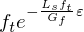

In [15]:
f_epsilon = f_w.subs({'w' : epsilon * L_s})
f_epsilon

Note the important fact that the integral of the softening function over the strains scales the dissipated energy by the term $1/L_\mathrm{s}$. 

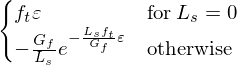

In [16]:
sp.integrate(f_epsilon, epsilon)

As a consequence, by changing the size of the softening zone we also change the total amount of the energy dissipated!!! This feature of the softening function will be exploited in the implementation of the finite elements.

## How to convert a softening function to damage function?

The shape of the softening function describes the process of deterioration - starting from an undamaged state and ending in a fully damage state. Let us establish an equivalence between softening and damage evolution by requiring that they describe the same kind of stress decay.

Considering the softening zone of the length $L_s$ let us describe the damage within this zone using the state variable $omega$ and the elastic modulus $E_c$

In [17]:
omega, E_c = sp.symbols('omega, E_c')

Then, the constitute law to be used in a finite element of the zone is given as

In [18]:
sigma = (1 - omega) * E_c * epsilon

The stress decay described by the damage law and by the softening law should be the same. Let them set equal and solve for the damage variable $omega$. Using the sympy solver we obtain the algebraic solution as

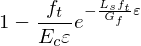

In [19]:
omega_Gf = sp.solve(sigma - f_epsilon, omega)[0]
omega_Gf

This new damage function is defined using material parameters with a clear mechanical interpretation. Such kind of material law is attractive because it makes it possible to design tests that focus on an isolated phenomenon, i.e. the determination of the material strength, E modulus or fracture energy.  

Let us now visually verify the shape of the damage function.
The set of parameters is assembled in a dictionary and then
they are all substituted into the damage function.

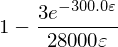

In [86]:
data_f = dict(E_c = 28000, f_t = 3, L_s = 1, G_f = 0.01)
omega_Gf_epsilon = omega_Gf.subs(data_f)
omega_Gf_epsilon

The damage function is only valid in an inelastic regime. Therefore, we have to quantify the onset of inelasticity first as
\begin{align}
\varepsilon_0 = \frac{f_t}{E_c}
\end{align}

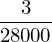

In [87]:
epsilon_0 = (f_t / E_c).subs(data_f)
epsilon_0

Then the damage function can be plotted as

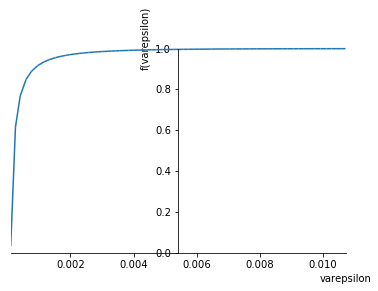

In [88]:
splot(omega_Gf_epsilon, (epsilon,epsilon_0,epsilon_0*100))

The corresponding stress strain curve has then the form

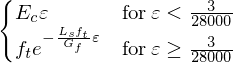

In [89]:
sigma = sp.Piecewise( (E_c * epsilon, epsilon < epsilon_0),
    (( 1 - omega_Gf ) * E_c * epsilon, epsilon >= epsilon_0))
sigma

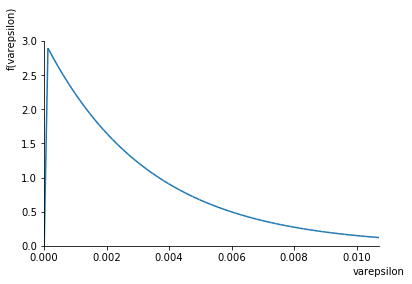

In [93]:
splot(sigma.subs(data_f), (epsilon,0,epsilon_0*100))

Note how the stress strain function scales with the change of the fracture energy and of the zone length.

Larger fracture energy makes the stress-strain response more ductile, while smaller makes it brittle.

On the other hand, larger size of the softening zone makes the softening behavior more brittle and smaller size of the zone makes it more ductile. Why?

In [101]:
g_f = sp.integrate(sigma, epsilon)